<h1 style="text-align: center;">H04U1C - Optimization of Mechatronic Systems</h1>

Consider the mass-spring-damper test setup depicted in the figure below, which you can consider as a model of quarter-car suspension.

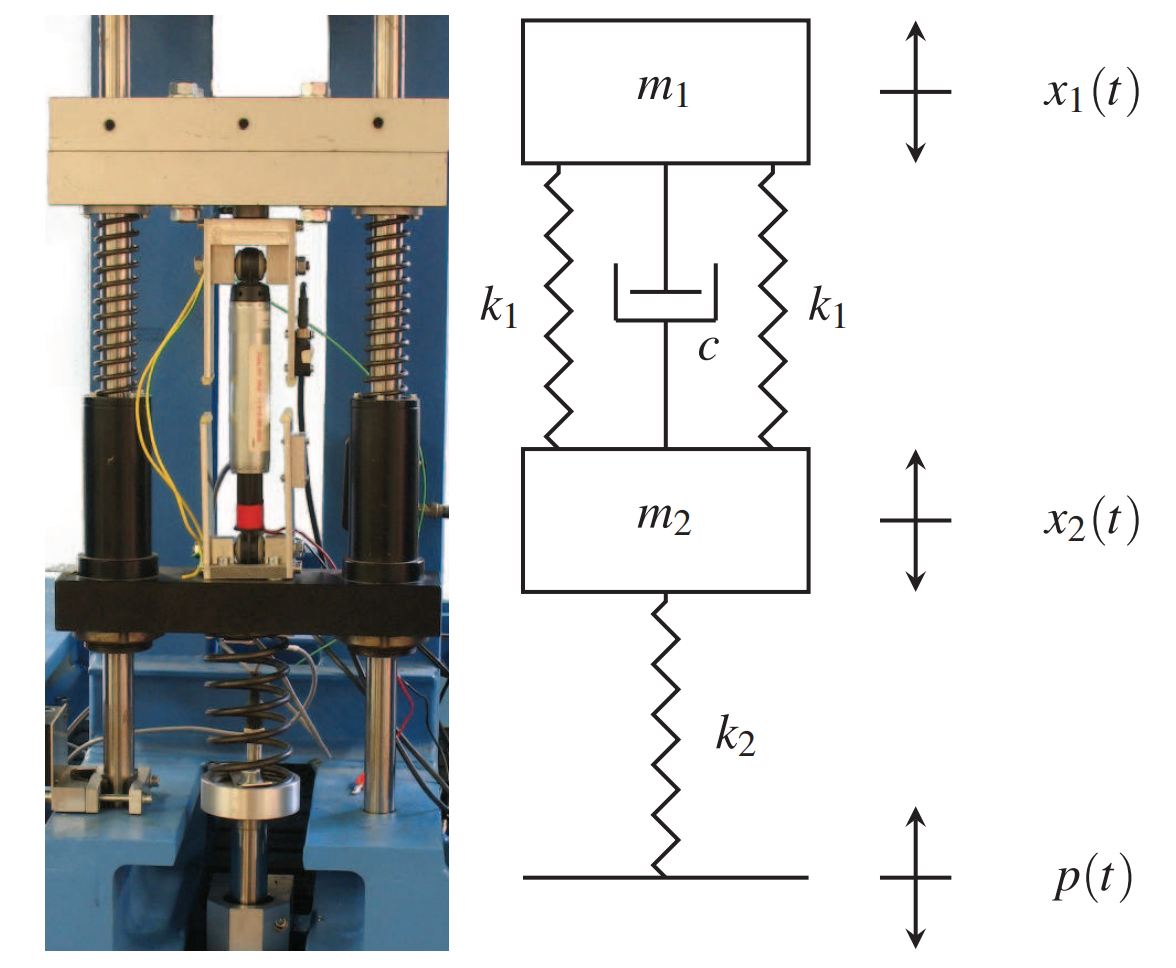

with

* $m_1 = 40 \text{ kg}$: mass of the quarter-car
* $2$*$k_1 = 9000 \frac{\text{ N}}{\text{ m}}$: stiffness of the suspension
* $c$: damping of the suspension
* $m_2 = 5 \text{ kg}$: mass of the tire
* $k_2 = 15000 \frac{\text{ N}}{\text{ m}}$: stiffness of the tire

Questions:

1. Write down the equations of motion of the quarter-car (in the time domain), in which you consider the road displacement $p(t)$ as a disturbance.

2. Simulate the behavior of the quarter-car, for a damping $c = 200 \frac{\text{ Ns}}{\text{ m}}$, starting from rest, subject to a step disturbance of $5 \text{ cm}$ in the road displacement. Plot the resulting evolution of the motion of the car as a function of time.

3. The quarter-car is equipped with a semiactive suspension, meaning that the damping $c$ is not a fixed value but can be controlled over time, hence, $c(t)$. In this assignment we make the simplified assumption that the damping can be changed instantaneously to any value between $c_{min}=0 \frac{\text{ Ns}}{\text{ m}}$ and $c_{max}=2000 \frac{\text{ Ns}}{\text{ m}}$, and we consider the following control law: 

    a. if $\dot{x}_1$ and $\dot{x}_1-\dot{x}_2$ have the same sign: $c = K \frac{\dot{x}_1}{\dot{x}_1-\dot{x}_2}$, but respecting to stay between $c_{min}$ and $c_{max}$.

    b. otherwise: $c = c_{min}$.

This is called the "skyhook control policy". Implement the equations of motion for the quarter-car with semiactive suspension. Simulate the system for a few values of $K$, for the same excitation as in question 2.

Hint: some useful CasADi functions: if_else, fmin, fmax, logsumexp. Check the CasADi documentation for more information.

4. Formulate two optimization problems to design 1) an optimal passive suspension, meaning a suspension with a fixed value of $c$, and 2) an optimal semi-active suspension with a skyhook control policy, meaning a suspension with a fixed value of $K$. Optimal means that the car body $x_1(t)$ deviates as little as possible from its steady-state value for a given road disturbance.

5. Solve both problems using CasADi-Opti with the Ipopt solver for a step disturbance of $1 \text{ cm}$, $5 \text{ cm}$, and $10 \text{ cm}$. Discuss the results.

6. Are your optimization problems convex? Motivate your answer.

7. What are computationally the most expensive parts when solving the system (look at the Ipopt output!)? Can you explain why this is the case? How would you speed up solving the problem?

# Solution

## Q1 - The equations of motion of the quarter-car are given by:

Car Body: $ \quad m_1 \ddot{x_1} = - 2 k_1 (x_1 - x_2) - c (\dot{x_1} - \dot{x_2}) $

Tire: $ \quad m_2 \ddot{x_2} = - k_2 (x_2 - p(t)) + 2 k_1 (x_1 - x_2) + c (\dot{x_1} - \dot{x_2}) $

## Q2 - Simulation of the quarter-car 

In [2]:
import numpy as np
from casadi import *
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define system parameters
m1 = 40  # kg
m2 = 5   # kg
k1 = 9000   # N/m
k2 = 15000  # N/m
c_std = 200  # Ns/m for Q2

# Skyhook control parameters
c_min = 0  # Ns/m
c_max = 2000  # Ns/m

# Define the step disturbance
def p(t, step_size):
    return step_size if t >= 0 else 0

# Define the control law for c(t)
def semiactive_suspension(x1_dot, x2_dot, K):
    if x1_dot * (x1_dot - x2_dot) > 0:
        c = K * x1_dot / (x1_dot - x2_dot)
        c = np.clip(c, c_min, c_max)
    else:
        c = c_min
    return c

# Define the equations of motion
def equations(t, y, K, damper, step_size, skyhook=False):
    x1, x2, x1_dot, x2_dot = y
    if skyhook:
        c = semiactive_suspension(x1_dot, x2_dot, K)
    else:
        c = damper
    x1_ddot = (-k1 * (x1 - x2) - c * (x1_dot - x2_dot)) / m1
    x2_ddot = (-k2 * (x2 - p(t, step_size)) + k1 * (x1 - x2) + c * (x1_dot - x2_dot)) / m2
    return [x1_dot, x2_dot, x1_ddot, x2_ddot]

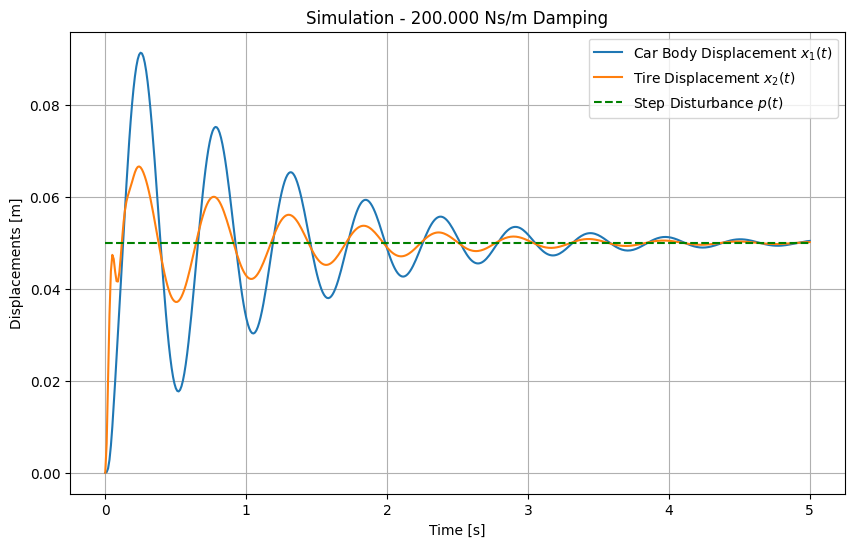

In [3]:
def Q2(c=c_std, step_size=0.05):
    # Initial conditions: [x1, x2, x1_dot, x2_dot]
    y0 = [0, 0, 0, 0]

    # Time span for the simulation
    t_span = (0, 5)  # 5 seconds
    t_eval = np.linspace(t_span[0], t_span[1], 500)

    # Solve the differential equations
    sol = solve_ivp(equations, t_span, y0, t_eval=t_eval, args=(0, c_std, step_size, False))

    # Extract the results
    x1 = sol.y[0]
    x2 = sol.y[1]
    t = sol.t

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(t, x1, label='Car Body Displacement $x_1(t)$')
    plt.plot(t, x2, label='Tire Displacement $x_2(t)$')
    plt.plot(t, [p(_, step_size) for _ in t], label='Step Disturbance $p(t)$', linestyle='--', color='green')
    plt.xlabel('Time [s]')
    plt.ylabel('Displacements [m]')
    plt.title(f'Simulation - {c:.3f} Ns/m Damping')
    plt.legend()
    plt.grid()
    plt.show()

# Run Q2
Q2()

## Q3 - Implementation of the skyhook control policy

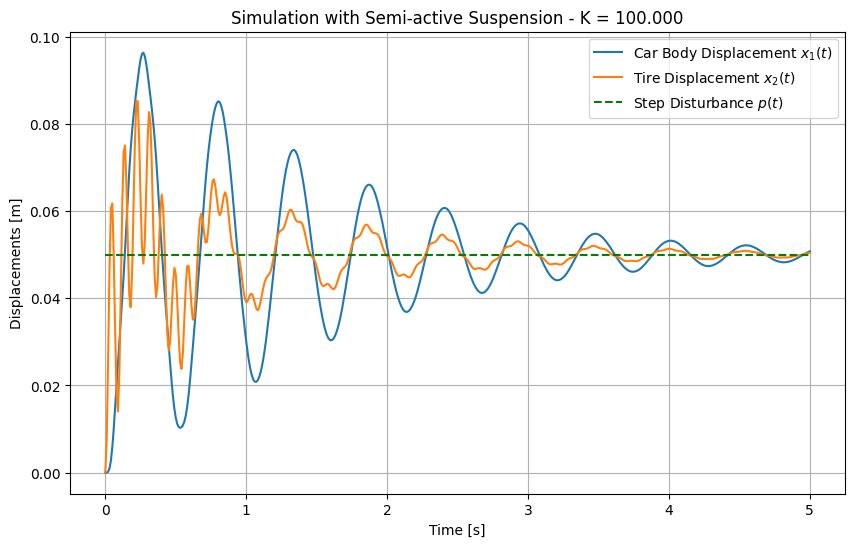

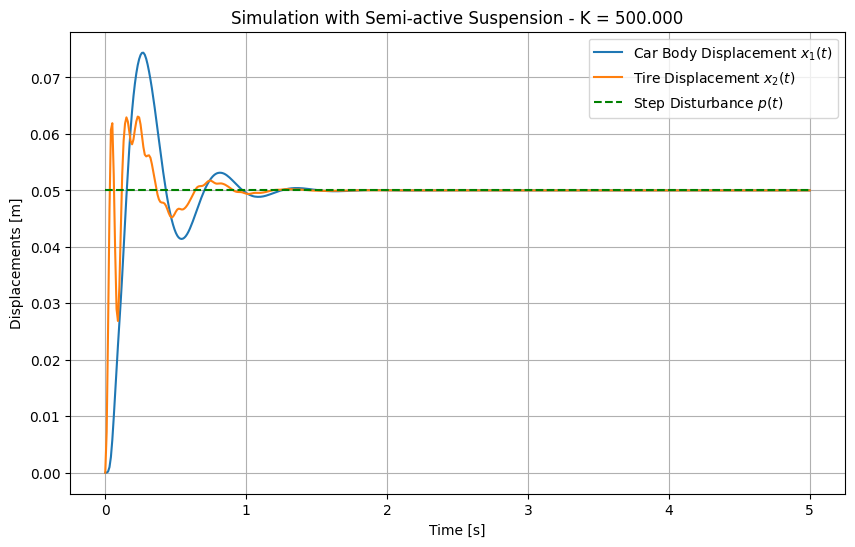

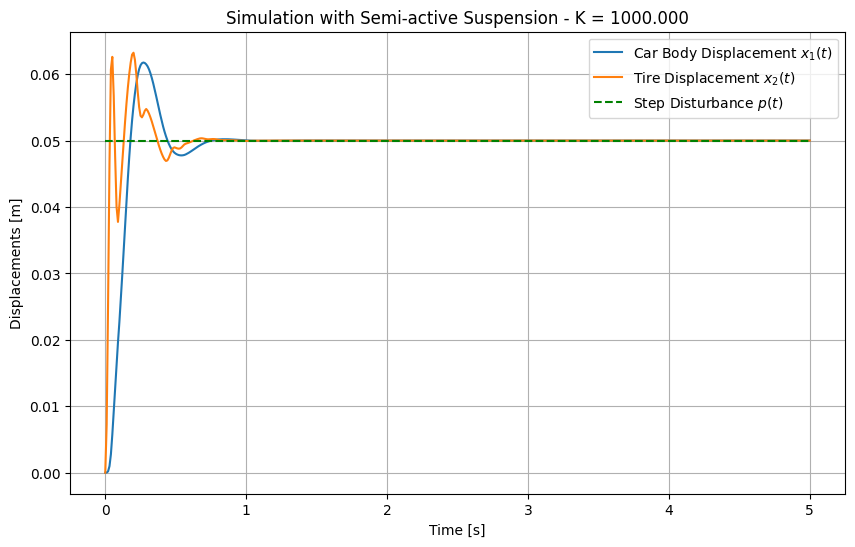

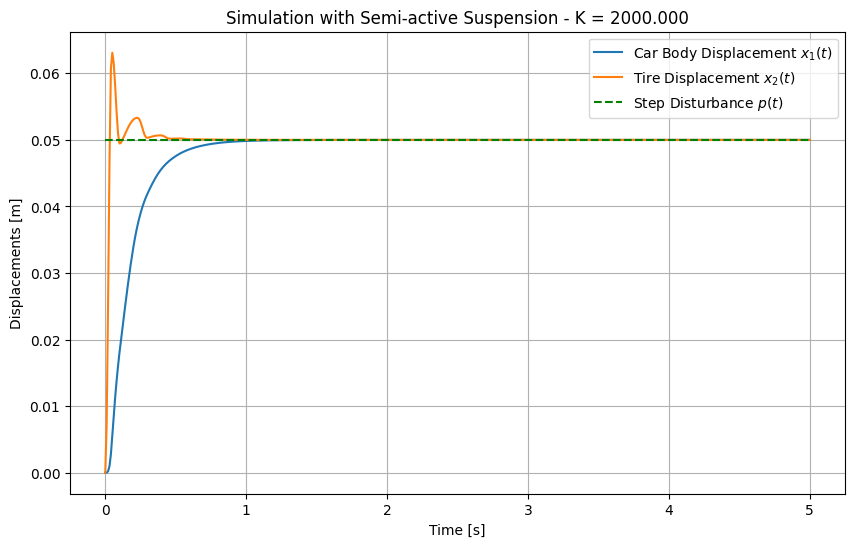

In [4]:
def Q3(K, step_size=0.05):
    # Initial conditions: [x1, x2, x1_dot, x2_dot]
    y0 = [0, 0, 0, 0]

    # Time span for the simulation
    t_span = (0, 5)  # 5 seconds
    t_eval = np.linspace(t_span[0], t_span[1], 500)

    # Solve the system of differential equations
    sol = solve_ivp(equations, t_span, y0, t_eval=t_eval, args=(K, c_std, step_size, True))

    # Extract the results
    x1 = sol.y[0]
    x2 = sol.y[1]
    t = sol.t

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(t, x1, label='Car Body Displacement $x_1(t)$')
    plt.plot(t, x2, label='Tire Displacement $x_2(t)$')
    plt.plot(t, [p(_, step_size) for _ in t], label='Step Disturbance $p(t)$', linestyle='--', color='green')
    plt.xlabel('Time [s]')
    plt.ylabel('Displacements [m]')
    plt.title(f'Simulation with Semi-active Suspension - K = {K:.3f}')
    plt.legend()
    plt.grid()
    plt.show()

# Run Q3 with a different values of K
K = [100, 500, 1000, 2000]
for k in K:
    Q3(k)

## Q4 & Q5 - Formulation of the optimization problems and solutions for three road disturbances

### Optimal passive suspension

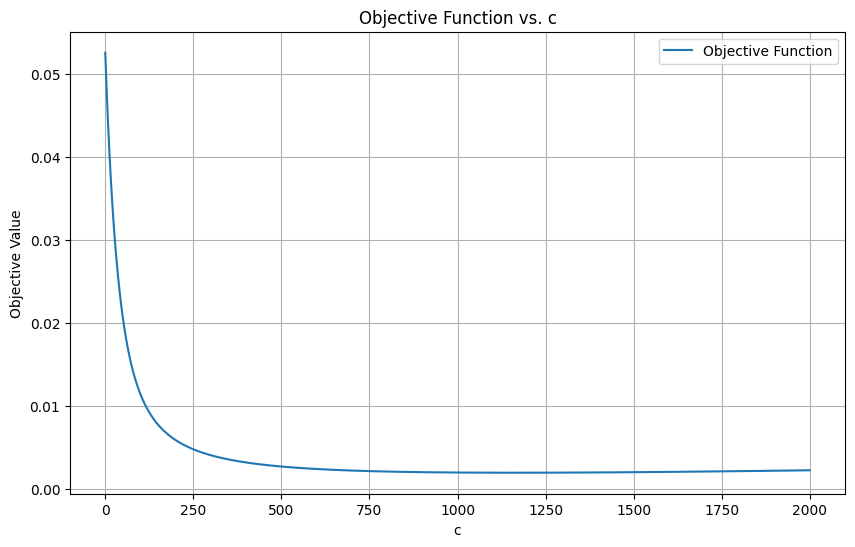

1165.1651651651653
Is the objective function convex? Yes
Optimal damping coefficient: 1165.0173532434744 Ns/m


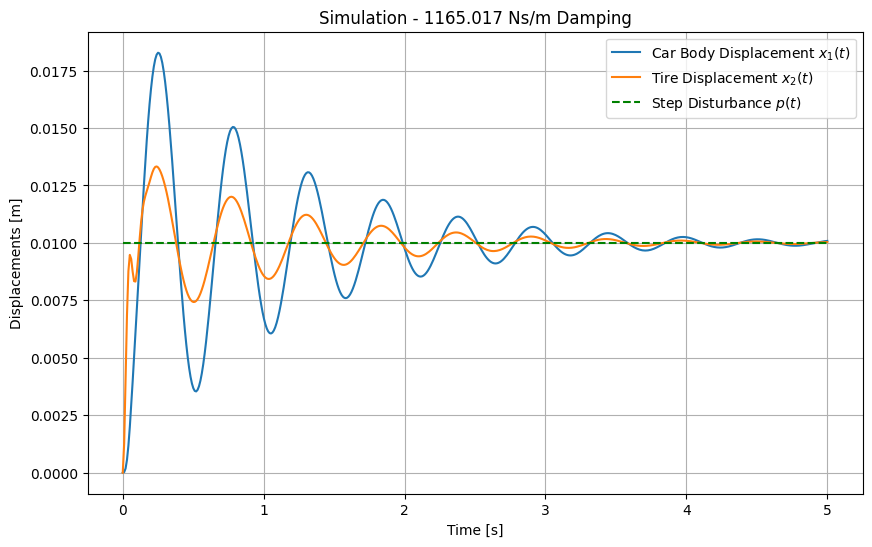

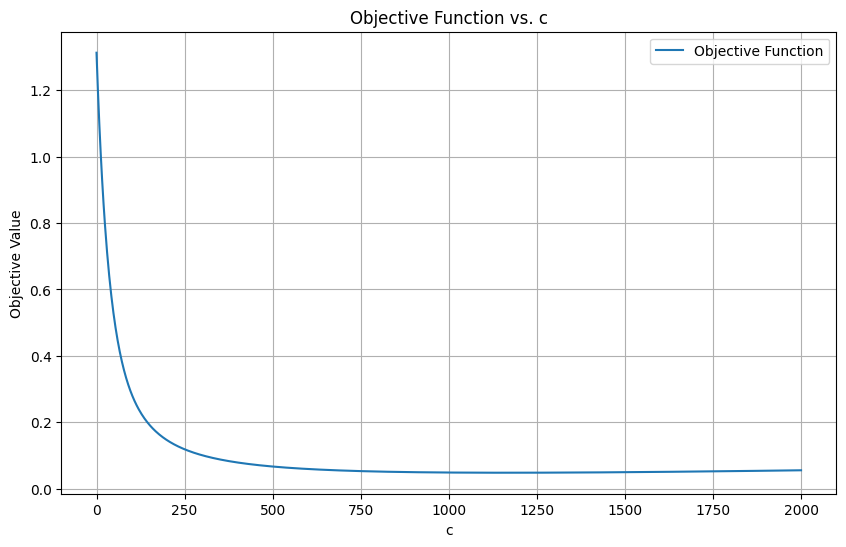

1165.1651651651653
Is the objective function convex? Yes
Optimal damping coefficient: 1165.0101731244395 Ns/m


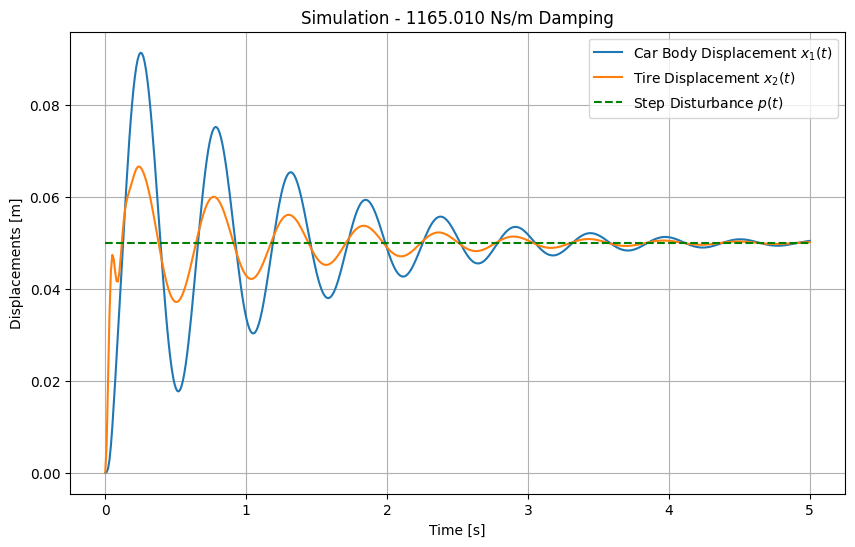

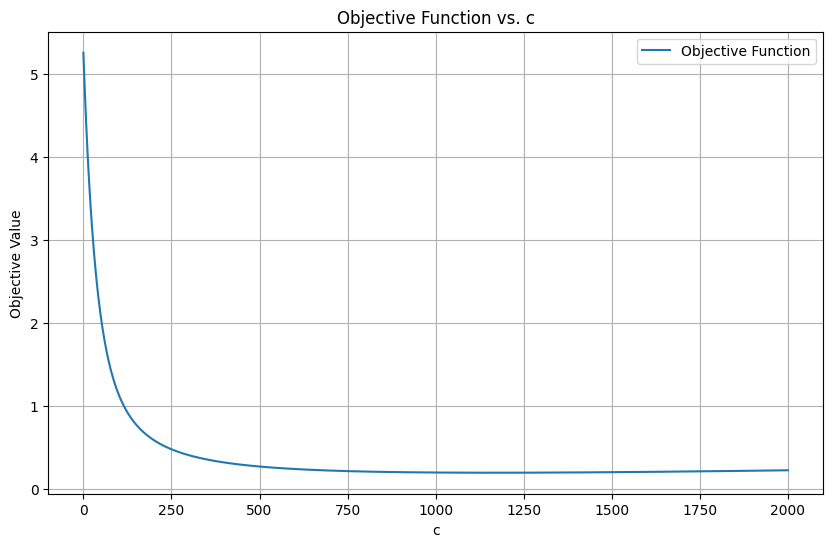

1165.1651651651653
Is the objective function convex? Yes
Optimal damping coefficient: 1165.0069172892222 Ns/m


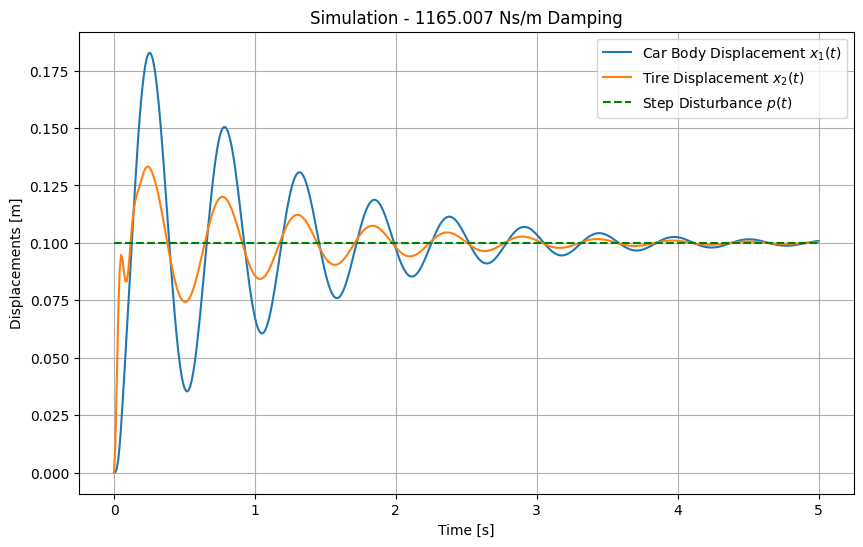

In [44]:
def Q4_1(step_size):
    T = 5  # Total simulation time

    # Define the optimization problem
    opti = Opti()

    # Decision variable and constraints (within reasonable bounds)
    c = opti.variable(1, 1)
    opti.subject_to(c_min <= c)
    opti.subject_to(c <= c_max)

    # Set an initial guess for c
    #initial_guess = 1000
    #opti.set_initial(c, initial_guess)

    # Time and state variables
    t = MX.sym('t')
    x = MX.sym('x', 4, 1)
    x1, x2, x1_dot, x2_dot = x[0], x[1], x[2], x[3]

    # Equations of motion
    x1_ddot = (-k1 * (x1 - x2) - c * (x1_dot - x2_dot)) / m1
    x2_ddot = (-k2 * (x2 - step_size) + k1 * (x1 - x2) + c * (x1_dot - x2_dot)) / m2
    rhs = vertcat(x1_dot, x2_dot, x1_ddot, x2_ddot)

    # Define the ODE function
    ode = {'x': x, 'p': vertcat(c, t), 'ode': rhs}
    F = integrator('F', 'cvodes', ode, {'tf': T/1000})

    # Initial conditions
    x0 = np.array([0, 0, 0, 0])

    # Simulate the system
    def simulate_system(c_val):
        x = x0
        x1_traj = []
        for i in range(1000):
            t_val = i * T / 1000
            res = F(x0=x, p=vertcat(c_val, t_val))
            x = res['xf']
            x1_traj.append(x[0]-step_size)
        return sum1(vertcat(*x1_traj)**2), np.sum(np.array(x1_traj)**2)

    # Evaluate the objective function over a range of values for c
    c_values = np.linspace(c_min, c_max, 1000)
    objective_values = [simulate_system(c_val)[1] for c_val in c_values]

    # Plot the objective function
    plt.figure(figsize=(10, 6))
    plt.plot(c_values, objective_values, label='Objective Function')
    plt.xlabel('c')
    plt.ylabel('Objective Value')
    plt.title('Objective Function vs. c')
    plt.legend()
    plt.grid()
    plt.show()

    # Objective function
    objective = simulate_system(c)[0]
    opti.minimize(objective)


    minima = []
    for i in range(1, len(objective_values)-1):
        if objective_values[i-1] >= objective_values[i] and objective_values[i+1] >= objective_values[i]:
            minima.append(c_values[i])
            print(c_values[i])
    print(f"Is the objective function convex? {'Yes' if len(minima) <= 1 else 'No'}")


    # Solve the optimization problem
    #opti.solver('ipopt')
    opti.solver("ipopt", {"print_time":False}, {"print_level":0}) # Suppress IPOPT output
    c_opt = opti.solve().value(c)
    print(f"Optimal damping coefficient: {c_opt} Ns/m")

    # Simulate the system with the optimal damping coefficient
    Q2(c=c_opt, step_size=step_size)


# Run Q4_1 with different step sizes
step_sizes = [0.01, 0.05, 0.1]
for step_size in step_sizes:
    Q4_1(step_size)

### Optimal semi-active suspension

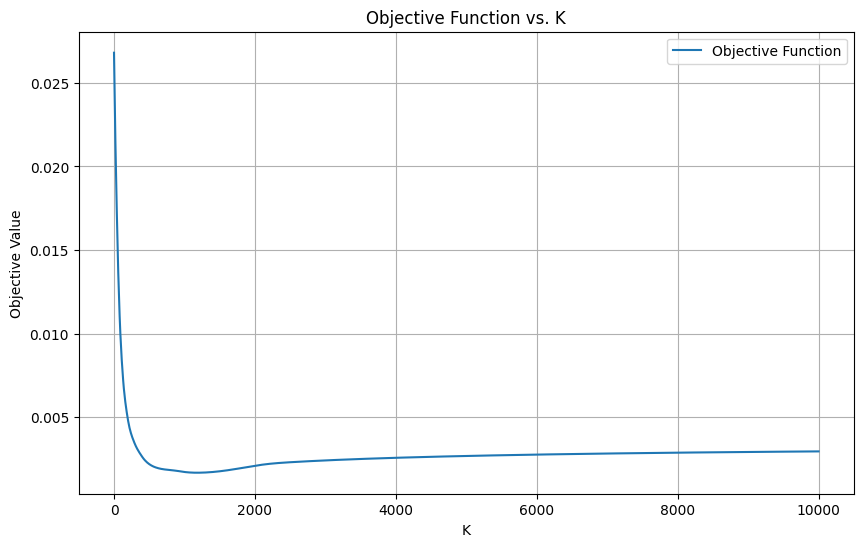

1181.1811811811813
Is the objective function convex? Yes
Optimal gain factor: 1180.0762054758748


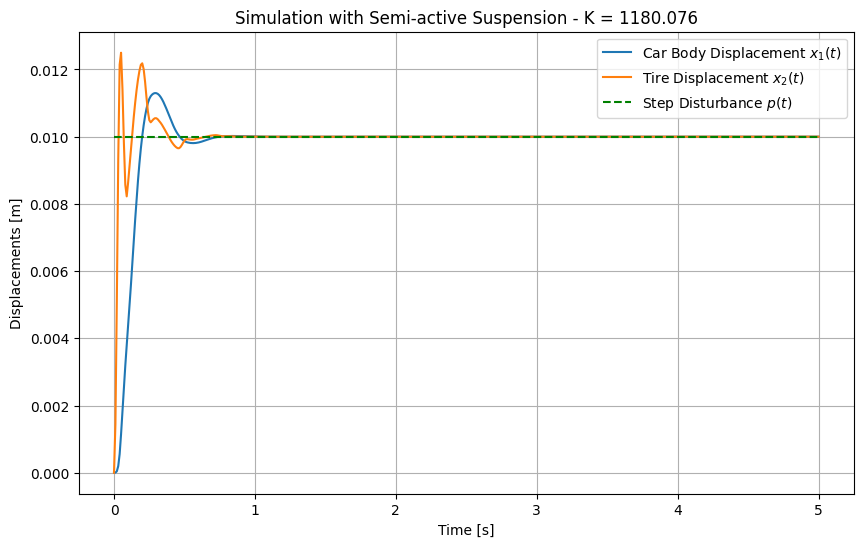

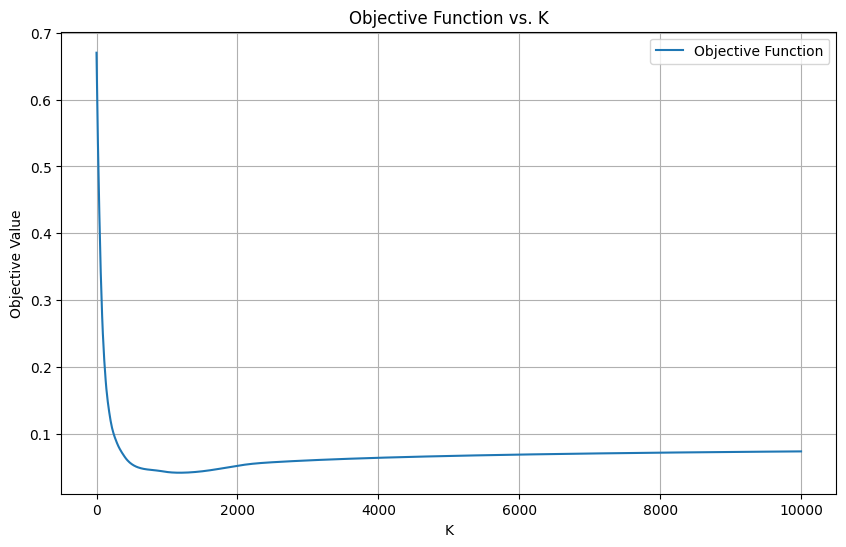

1181.1811811811813
Is the objective function convex? Yes
Optimal gain factor: 1179.773998910609


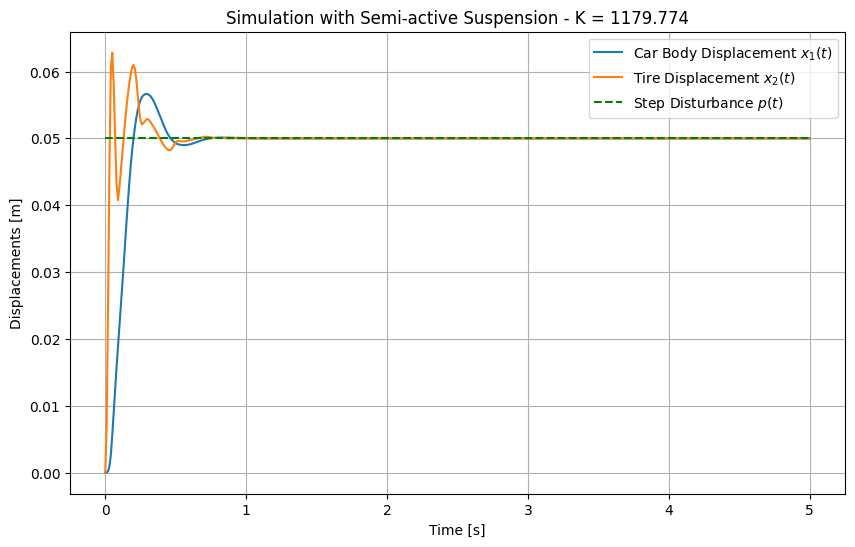

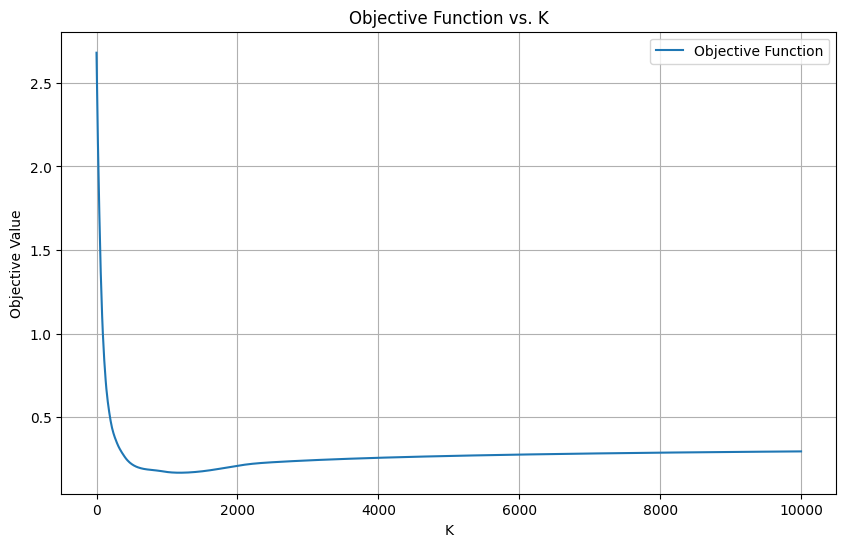

1181.1811811811813
Is the objective function convex? Yes
Optimal gain factor: 1179.7710627460067


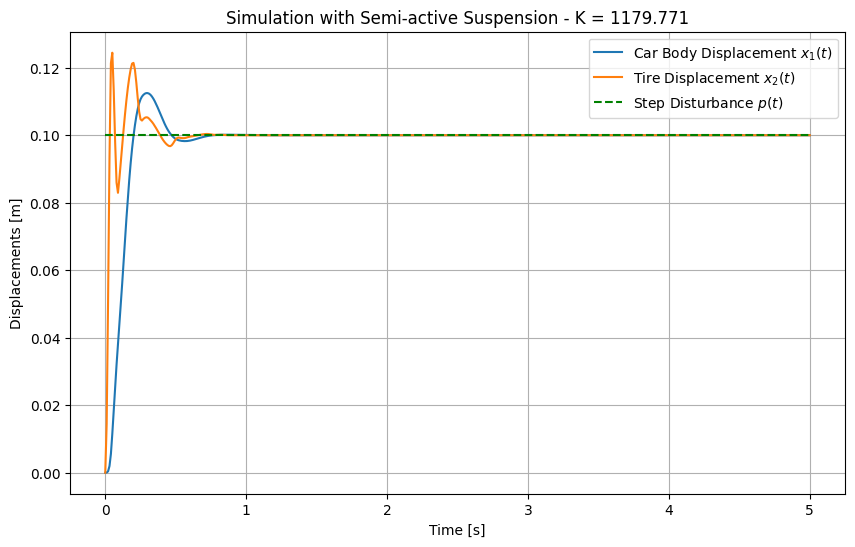

In [45]:
# Optimal semi-active suspension (optimal value of K)
def Q4_2(step_size):
    T = 5  # Total simulation time
    K_min = 0
    K_max = 10000

    # Define the optimization problem
    opti = Opti()

    # Decision variable and constraints (within reasonable bounds)
    K = opti.variable(1, 1)

    # Set an initial guess for K
    initial_guess = 1000
    opti.set_initial(K, initial_guess)

    # Time and state variables
    t = MX.sym('t')
    x = MX.sym('x', 4, 1)
    x1, x2, x1_dot, x2_dot = x[0], x[1], x[2], x[3]

    def casadi_semiactive_suspension(x1_dot, x2_dot, K):
        condition = x1_dot * (x1_dot - x2_dot) > 0
        c = if_else(condition, K * x1_dot / (x1_dot - x2_dot), c_min)
        c = fmin(c, c_max)
        return c

    # Equations of motion
    x1_ddot = (-k1 * (x1 - x2) - casadi_semiactive_suspension(x1_dot, x2_dot, K) * (x1_dot - x2_dot)) / m1
    x2_ddot = (-k2 * (x2 - step_size) + k1 * (x1 - x2) + casadi_semiactive_suspension(x1_dot, x2_dot, K) * (x1_dot - x2_dot)) / m2
    rhs = vertcat(x1_dot, x2_dot, x1_ddot, x2_ddot)

    # Define the ODE function
    ode = {'x': x, 'p': vertcat(K, t), 'ode': rhs}
    F = integrator('F', 'cvodes', ode, {'tf': T/1000})

    # Initial conditions
    x0 = np.array([0, 0, 0, 0])

    # Simulate the system
    def simulate_system(K_val):
        x = x0
        x1_traj = []
        for i in range(500):
            t_val = i * T / 1000
            res = F(x0=x, p=vertcat(K_val, t_val))
            x = res['xf']
            x1_traj.append(x[0]-step_size)
        return sum1(vertcat(*x1_traj)**2), np.sum(np.array(x1_traj)**2)

    # Evaluate the objective function over a range of values for c
    K_values = np.linspace(K_min, K_max, 1000)
    objective_values = [simulate_system(K_val)[1] for K_val in K_values]

    # Plot the objective function
    plt.figure(figsize=(10, 6))
    plt.plot(K_values, objective_values, label='Objective Function')
    plt.xlabel('K')
    plt.ylabel('Objective Value')
    plt.title('Objective Function vs. K')
    plt.legend()
    plt.grid()
    plt.show()


    minima = []
    for i in range(1, len(objective_values)-1):
        if objective_values[i-1] >= objective_values[i] and objective_values[i+1] >= objective_values[i]:
            minima.append(K_values[i])
            print(K_values[i])
    print(f"Is the objective function convex? {'Yes' if len(minima) <= 1 else 'No'}")


    # Objective function
    objective = simulate_system(K)[0]
    opti.minimize(objective)

    # Solve the optimization problem
    #opti.solver('ipopt')
    opti.solver("ipopt", {"print_time":False}, {"print_level":0}) # Suppress IPOPT output
    K_opt = opti.solve().value(K)
    print(f"Optimal gain factor: {K_opt}")

    # Simulate the system with the optimal gain factor
    Q3(K_opt, step_size)


# Run Q4_2 with different step sizes
step_sizes = [0.01, 0.05, 0.1]
for step_size in step_sizes:
    Q4_2(step_size)

## Q6 - Convexity of the optimization problems (TO CHECK)
### 1. Optimal passive suspension problem: 
1. The decision variables are $c$ and $x_1(t)$. $c$ is constrained to be whithin the range $[c_{min}, c_{max}]$ which is a convex constraints.
2. The equation of motion of the car body define $\ddot{x}_1$ and $\ddot{x}_2$. These involve nonlinear terms such as products of the damping coefficient $c$ and velocity differences, making the dynamics nonlinear. (not sure about this)
3. The objective function is the squared deviation of the car body from its steady-state value. However $x_1$ depends on the nonlinear dynamics, so the relationship is nonlinear.

The optimization problem is not guaranteed to be convex because:
- The dynamics are nonlinear and introduce non-convexity into the system.
- The objective function is based on these dynamics and is thus likely to be non-convex.

### 2. Optimal semi-active suspension problem:
1. The decision variables are $K$ and $x_1(t)$. $K$ is constrained to be whithin the range $[K_{min}, K_{max}]$ which is a convex constraints.
2. The function that defines the damping coefficient $c$ is a piecewise function of the velocity differences. It uses "if_else" structure, which introduces nonlinearity due to conditional branching. Additionally, there is a min-operator adding more nonlinearity. (As a consequence it is not convex - not sure about this)
3. The equation of motion for $\ddot{x}_1$ and $\ddot{x}_2$ involve the nonlinear function "casadi_semiactive_suspension", making the dynamics non-affine and likely non-convex in $K$.

This optimization problem is not convex because:
- The function "casadi_semiactive_suspension" introduces significant nonlinearity and non-convexity.
- The dynamics depend on this nonlinear function, propagating non-convexity to the objective function.

## Q7 - Computational complexity of the optimization problems

### 1. Optimal passive suspension problem:

The most expensive parts of the optimization problem are the computation of the Hessian of the Lagrangian and the computation of the gradient of the objective function. This is because the Ipopt solver uses these quantities to determine the search direction and the step size at each iteration. The Hessian is particularly expensive to compute because it involves second-order derivatives of the objective function and the constraints.

- Displacement of $1 \text{ cm}$:
```
EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 161.00ms ( 12.38ms) 171.96ms ( 13.23ms)        13
       nlp_g  |        0 (       0)  37.00us (  2.85us)        13
  nlp_grad_f  | 835.00ms ( 59.64ms) 831.02ms ( 59.36ms)        14
  nlp_hess_l  |   2.89 s (240.67ms)   2.88 s (240.22ms)        12
   nlp_jac_g  |        0 (       0)  24.00us (  1.71us)        14
       total  |   3.90 s (  3.90 s)   3.90 s (  3.90 s)         1
```

- Displacement of $5 \text{ cm}$:
```
EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 187.00ms ( 13.36ms) 201.99ms ( 14.43ms)        14
       nlp_g  |        0 (       0)  43.00us (  3.07us)        14
  nlp_grad_f  | 960.00ms ( 64.00ms) 947.89ms ( 63.19ms)        15
  nlp_hess_l  |   3.35 s (257.69ms)   3.35 s (257.72ms)        13
   nlp_jac_g  |        0 (       0)  23.00us (  1.53us)        15
       total  |   4.51 s (  4.51 s)   4.51 s (  4.51 s)         1
```

- Displacement of $10 \text{ cm}$:
```
EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   3.71 s ( 10.05ms)   3.68 s (  9.98ms)       369
       nlp_g  |        0 (       0) 232.00us (628.73ns)       369
  nlp_grad_f  |   1.49 s ( 57.12ms)   1.49 s ( 57.15ms)        26
  nlp_hess_l  |   5.42 s (225.92ms)   5.46 s (227.47ms)        24
   nlp_jac_g  |        0 (       0)  51.00us (  1.96us)        26
       total  |  10.67 s ( 10.67 s)  10.67 s ( 10.67 s)         1
```


### 2. Optimal semi-active suspension problem:

